<a href="https://colab.research.google.com/github/isidoragajic/AS12/blob/main/AS12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

### Name: Isidora Gajic  
### Course: AI for Finance  
### Assignment 12: Clustering Text Embeddings Obtained from Fine-tuned Language Model
### Date: November 19, 2024  

---

### Disclaimer:

This notebook was developed with the assistance of ChatGPT, an AI language model. While the majority of the code was generated with the help of ChatGPT, the conceptualization of the analysis, selection of specific metrics, and the overall approach were directed by me. I reviewed and tweaked the code to ensure it aligns with the objectives of the assignment and meets the required standards.

The analysis and conclusions presented in this document are my own. ChatGPT was used to improve the cohesiveness and fluency of my original writing and to convert text from a Word document into Markdown. All final interpretations, decisions, and the overall approach to the analysis are entirely mine.

---

## **Importing Necessary Libraries**

In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import wandb
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from typing import Dict
import json
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import wandb
from matplotlib.lines import Line2D

## **Cloning the GitHub Repository and Unzipping Data Files**

In [2]:
# Define the repository URL and the local directory name
repo_url = 'https://github.com/isidoragajic/AS12.git'
repo_dir = 'AS12'

# Check if the repository directory exists
if not os.path.exists(repo_dir):
    # Clone the repository (assuming GitHub account is connected)
    !git clone {repo_url}
else:
    print(f"Repository '{repo_dir}' already exists. Skipping clone.")

# Change directory to the cloned repository
%cd {repo_dir}

# Check if the unzipped data directory exists
data_zip = 'business_description_10K.zip'
data_dir = 'business_description_10K'

if not os.path.exists(data_dir):
    # Unzip the business_description_10K.zip file
    !unzip {data_zip} -d {data_dir}
else:
    print(f"Data directory '{data_dir}' already exists. Skipping unzip.")


Streaming output truncated to the last 5000 lines.
  inflating: business_description_10K/10K_item1_PERMNO/0001047469-98-011745.json  
  inflating: business_description_10K/10K_item1_PERMNO/0000912057-02-013127.json  
  inflating: business_description_10K/10K_item1_PERMNO/0000950123-11-019050.json  
  inflating: business_description_10K/10K_item1_PERMNO/0000020212-16-000065.json  
  inflating: business_description_10K/10K_item1_PERMNO/0001104659-03-004939.json  
  inflating: business_description_10K/10K_item1_PERMNO/0001297184-17-000007.json  
  inflating: business_description_10K/10K_item1_PERMNO/0000924515-04-000008.json  
  inflating: business_description_10K/10K_item1_PERMNO/0001193125-18-052951.json  
  inflating: business_description_10K/10K_item1_PERMNO/0000708955-12-000012.json  
  inflating: business_description_10K/10K_item1_PERMNO/0001019687-02-000546.json  
  inflating: business_description_10K/10K_item1_PERMNO/0000950123-10-030572.json  
  inflating: business_description_10

## **Step 1: Preparing the Dataset**

### **1. Loading and Exploring Sampled Companies Data**

Load the `sample_company.csv` file and examine its structure to ensure the `PERMNO` column is correctly formatted.

In [3]:
# Load the sampled companies data
sampled_companies = pd.read_csv('sample_company.csv')

# Display the first few rows to check the data structure
print(sampled_companies.head())

# Check data types
print(sampled_companies.dtypes)


   label  year                                             PERMNO
0      0  1996  [11614, 76862, 77056, 82225, 20598, 16468, 762...
1      0  1997  [12006, 67619, 54981, 16468, 84422, 85213, 116...
2      0  1998  [20598, 76950, 77730, 76264, 85982, 84422, 117...
3      0  1999  [77730, 85037, 85982, 85951, 77099, 51190, 839...
4      0  2000  [85213, 85982, 87021, 12282, 77099, 11614, 164...
label      int64
year       int64
PERMNO    object
dtype: object


Since the 'PERMNO' column contains strings representing lists, convert them into actual lists.

In [4]:
# Import the ast module to safely evaluate strings of lists
import ast

# Define a function to convert string representations of lists into actual lists
def convert_to_list(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return x

# Apply the function to the 'PERMNO' column
sampled_companies['PERMNO'] = sampled_companies['PERMNO'].apply(convert_to_list)


Expand the DataFrame so that each PERMNO is in a separate row.

In [5]:
# Check if any entries in 'PERMNO' are lists
if sampled_companies['PERMNO'].apply(lambda x: isinstance(x, list)).any():
    # Explode the lists into separate rows
    sampled_companies = sampled_companies.explode('PERMNO').reset_index(drop=True)
    # Convert 'PERMNO' to integer type
    sampled_companies['PERMNO'] = sampled_companies['PERMNO'].astype(int)


Verify the data after processing.

In [6]:
# Display the first few rows after processing
print(sampled_companies.head())


   label  year  PERMNO
0      0  1996   11614
1      0  1996   76862
2      0  1996   77056
3      0  1996   82225
4      0  1996   20598


### **2. Building a Mapping from (PERMNO, Year) to JSON Filenames**

Since the JSON files are named differently and the `PERMNO` is located at the end of the JSON file, we'll read each JSON file, extract the `PERMNO` and `filing_date`, and build a mapping from `(PERMNO, year)` to filenames.

In [7]:
# Directory containing the JSON files
json_dir = '/content/AS12/business_description_10K/10K_item1_PERMNO'

# Initialize a mapping from (PERMNO, year) to a list of filenames
permno_year_to_filenames = {}

# List all JSON files in the directory
json_files = [f for f in os.listdir(json_dir) if f.endswith('.json')]

# Iterate over each JSON file to build the mapping
for json_file in tqdm(json_files, desc='Indexing JSON files'):
    json_path = os.path.join(json_dir, json_file)

    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

            # Extract PERMNO and filing_date
            permno = data.get('PERMNO')
            filing_date = data.get('filing_date')

            # Check if PERMNO and filing_date are available
            if permno and filing_date:
                # Extract the year from the filing_date
                year = int(filing_date[:4])  # Assuming filing_date is in 'YYYY-MM-DD' format

                # Add to the mapping
                key = (int(permno), year)

                # Initialize the list if the key is not present
                if key not in permno_year_to_filenames:
                    permno_year_to_filenames[key] = []

                # Append the filename to the list for this key
                permno_year_to_filenames[key].append(json_file)
            else:
                # Handle missing data if necessary
                print(f"Missing PERMNO or filing_date in file: {json_file}")
    except json.JSONDecodeError:
        print(f"Error decoding JSON file: {json_file}")


Indexing JSON files: 100%|██████████| 110294/110294 [00:13<00:00, 8100.72it/s]


In [8]:
print(permno_year_to_filenames)

{(68591, 2003): ['0000897101-03-000221.json'], (46886, 2004): ['0001206774-04-001081.json'], (85079, 2007): ['0000950123-07-004659.json'], (29073, 2017): ['0001206774-17-000958.json'], (87634, 2000): ['0000927016-00-001081.json'], (89411, 2017): ['0001144204-17-052475.json'], (84029, 1999): ['0000950131-99-001834.json'], (75825, 2016): ['0000821189-16-000054.json'], (89891, 2013): ['0001140361-13-014654.json'], (14434, 2015): ['0001590976-15-000075.json'], (16856, 2014): ['0001553350-14-000845.json'], (87248, 2001): ['0000950131-01-504365.json'], (91571, 2007): ['0001367644-07-000013.json'], (80634, 2014): ['0001493152-14-003836.json'], (85418, 2018): ['0000750686-18-000057.json'], (14951, 2020): ['0001474903-20-000011.json'], (91500, 2009): ['0001193125-09-055465.json'], (70659, 2000): ['0000922423-00-000535.json'], (82593, 2005): ['0000950134-05-000551.json', '0000950134-05-023207.json'], (14295, 2017): ['0001564590-17-002584.json'], (20053, 2007): ['0000950144-07-001763.json'], (468

### **3. Gathering Business Descriptions of Sampled Companies**

Use the mapping to find the corresponding JSON file(s) for each company in `sampled_companies`.

In [9]:
# Initialize a list to store the dataset
dataset = []

# Initialize a list to store missing (PERMNO, Year) pairs
missing_files = []

# Iterate over each row in the sampled companies DataFrame
for idx, row in tqdm(sampled_companies.iterrows(), total=sampled_companies.shape[0], desc='Processing Companies'):
    permno = int(row['PERMNO'])
    year = int(row['year'])
    label = int(row['label'])

    key = (permno, year)

    # Check if the key exists in the mapping
    if key in permno_year_to_filenames:
        json_filenames = permno_year_to_filenames[key]

        # For each file corresponding to this key
        for json_filename in json_filenames:
            json_path = os.path.join(json_dir, json_filename)

            with open(json_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                # Extract the business description from 'item_1' or other relevant sections
                business_description = data.get('item_1', '')

                # Append the data to the dataset if business_description is not empty
                if business_description.strip():
                    dataset.append({
                        'PERMNO': permno,
                        'year': year,
                        'label': label,
                        'text': business_description
                    })
                else:
                    # If the business description is empty, consider it as missing
                    missing_files.append(key)
    else:
        # Handle missing files
        print(f"No JSON file found for PERMNO: {permno}, Year: {year}")
        missing_files.append(key)

# After processing all companies, output the total number of missing files
total_companies = sampled_companies.shape[0]
missing_count = len(missing_files)
print(f"\nTotal number of companies processed: {total_companies}")
print(f"Total number of missing files: {missing_count}")
print(f"Percentage of missing files: {missing_count / total_companies * 100:.2f}%")

# Optionally, save the missing files list
missing_df = pd.DataFrame(missing_files, columns=['PERMNO', 'Year'])
missing_df.to_csv('missing_files.csv', index=False)


Processing Companies:  13%|█▎        | 368/2726 [00:00<00:00, 3659.59it/s]

No JSON file found for PERMNO: 11614, Year: 1996
No JSON file found for PERMNO: 76862, Year: 1996
No JSON file found for PERMNO: 77056, Year: 1996
No JSON file found for PERMNO: 82225, Year: 1996
No JSON file found for PERMNO: 20598, Year: 1996
No JSON file found for PERMNO: 76264, Year: 1996
No JSON file found for PERMNO: 77099, Year: 1996
No JSON file found for PERMNO: 67619, Year: 1997
No JSON file found for PERMNO: 54981, Year: 1997
No JSON file found for PERMNO: 84422, Year: 1997
No JSON file found for PERMNO: 85213, Year: 1997
No JSON file found for PERMNO: 26650, Year: 1997
No JSON file found for PERMNO: 91708, Year: 1997
No JSON file found for PERMNO: 77022, Year: 1997
No JSON file found for PERMNO: 76950, Year: 1998
No JSON file found for PERMNO: 84422, Year: 1998
No JSON file found for PERMNO: 12282, Year: 1998
No JSON file found for PERMNO: 77056, Year: 1998
No JSON file found for PERMNO: 77730, Year: 1999
No JSON file found for PERMNO: 85037, Year: 1999
No JSON file found f

Processing Companies:  27%|██▋       | 736/2726 [00:00<00:00, 3670.40it/s]

No JSON file found for PERMNO: 46923, Year: 2023
No JSON file found for PERMNO: 17221, Year: 2023
No JSON file found for PERMNO: 92601, Year: 2023
No JSON file found for PERMNO: 78841, Year: 2023
No JSON file found for PERMNO: 15139, Year: 2023
No JSON file found for PERMNO: 23819, Year: 2023
No JSON file found for PERMNO: 90533, Year: 2023
No JSON file found for PERMNO: 13124, Year: 2023
No JSON file found for PERMNO: 19894, Year: 2023
No JSON file found for PERMNO: 93083, Year: 2023
No JSON file found for PERMNO: 66245, Year: 1996
No JSON file found for PERMNO: 82829, Year: 1996
No JSON file found for PERMNO: 75878, Year: 1996
No JSON file found for PERMNO: 80309, Year: 1996
No JSON file found for PERMNO: 81776, Year: 1996
No JSON file found for PERMNO: 10097, Year: 1996
No JSON file found for PERMNO: 75149, Year: 1996
No JSON file found for PERMNO: 47141, Year: 1996
No JSON file found for PERMNO: 80309, Year: 1997
No JSON file found for PERMNO: 29621, Year: 1997
No JSON file found f

Processing Companies:  41%|████      | 1123/2726 [00:00<00:00, 3758.73it/s]

No JSON file found for PERMNO: 20344, Year: 2023
No JSON file found for PERMNO: 52708, Year: 2023
No JSON file found for PERMNO: 75342, Year: 2023
No JSON file found for PERMNO: 91665, Year: 2023
No JSON file found for PERMNO: 14716, Year: 2023
No JSON file found for PERMNO: 85059, Year: 2023
No JSON file found for PERMNO: 63132, Year: 2023
No JSON file found for PERMNO: 82694, Year: 2023
No JSON file found for PERMNO: 91579, Year: 2023
No JSON file found for PERMNO: 10158, Year: 2023
No JSON file found for PERMNO: 77058, Year: 1996
No JSON file found for PERMNO: 84095, Year: 1996
No JSON file found for PERMNO: 25582, Year: 1996
No JSON file found for PERMNO: 82559, Year: 1996
No JSON file found for PERMNO: 75477, Year: 1997
No JSON file found for PERMNO: 10989, Year: 1997
No JSON file found for PERMNO: 85310, Year: 1997
No JSON file found for PERMNO: 43634, Year: 1997
No JSON file found for PERMNO: 20394, Year: 1997
No JSON file found for PERMNO: 83822, Year: 1997
No JSON file found f

Processing Companies:  55%|█████▍    | 1499/2726 [00:00<00:00, 3662.71it/s]

No JSON file found for PERMNO: 61188, Year: 2014
No JSON file found for PERMNO: 61946, Year: 2014
No JSON file found for PERMNO: 24010, Year: 2015
No JSON file found for PERMNO: 13429, Year: 2015
No JSON file found for PERMNO: 12173, Year: 2015
No JSON file found for PERMNO: 62368, Year: 2016
No JSON file found for PERMNO: 58334, Year: 2017
No JSON file found for PERMNO: 27991, Year: 2017
No JSON file found for PERMNO: 44206, Year: 2017
No JSON file found for PERMNO: 16697, Year: 2017
No JSON file found for PERMNO: 89525, Year: 2017
No JSON file found for PERMNO: 27959, Year: 2018
No JSON file found for PERMNO: 89525, Year: 2018
No JSON file found for PERMNO: 75104, Year: 2018
No JSON file found for PERMNO: 21776, Year: 2018
No JSON file found for PERMNO: 84723, Year: 2019
No JSON file found for PERMNO: 12873, Year: 2019
No JSON file found for PERMNO: 91063, Year: 2019
No JSON file found for PERMNO: 14778, Year: 2019
No JSON file found for PERMNO: 12308, Year: 2019
No JSON file found f

Processing Companies:  69%|██████▉   | 1889/2726 [00:00<00:00, 3745.28it/s]

No JSON file found for PERMNO: 77780, Year: 2013
No JSON file found for PERMNO: 90207, Year: 2015
No JSON file found for PERMNO: 16082, Year: 2016
No JSON file found for PERMNO: 77780, Year: 2016
No JSON file found for PERMNO: 16653, Year: 2017
No JSON file found for PERMNO: 15724, Year: 2021
No JSON file found for PERMNO: 83112, Year: 2023
No JSON file found for PERMNO: 92400, Year: 2023
No JSON file found for PERMNO: 80362, Year: 2023
No JSON file found for PERMNO: 92471, Year: 2023
No JSON file found for PERMNO: 80320, Year: 2023
No JSON file found for PERMNO: 86876, Year: 2023
No JSON file found for PERMNO: 29612, Year: 2023
No JSON file found for PERMNO: 80951, Year: 2023
No JSON file found for PERMNO: 76128, Year: 2023
No JSON file found for PERMNO: 48961, Year: 2023
No JSON file found for PERMNO: 12253, Year: 1996
No JSON file found for PERMNO: 80011, Year: 1996
No JSON file found for PERMNO: 78900, Year: 1996
No JSON file found for PERMNO: 82713, Year: 1996
No JSON file found f

Processing Companies:  96%|█████████▌| 2620/2726 [00:00<00:00, 3504.80it/s]

No JSON file found for PERMNO: 83823, Year: 1998
No JSON file found for PERMNO: 84721, Year: 1998
No JSON file found for PERMNO: 84540, Year: 1998
No JSON file found for PERMNO: 85712, Year: 1999
No JSON file found for PERMNO: 82178, Year: 1999
No JSON file found for PERMNO: 87035, Year: 1999
No JSON file found for PERMNO: 65103, Year: 1999
No JSON file found for PERMNO: 87377, Year: 1999
No JSON file found for PERMNO: 84560, Year: 1999
No JSON file found for PERMNO: 85270, Year: 1999
No JSON file found for PERMNO: 83128, Year: 2000
No JSON file found for PERMNO: 81137, Year: 2000
No JSON file found for PERMNO: 84540, Year: 2000
No JSON file found for PERMNO: 86957, Year: 2000
No JSON file found for PERMNO: 87134, Year: 2000
No JSON file found for PERMNO: 11781, Year: 2000
No JSON file found for PERMNO: 80946, Year: 2000
No JSON file found for PERMNO: 80037, Year: 2001
No JSON file found for PERMNO: 88534, Year: 2001
No JSON file found for PERMNO: 82307, Year: 2001
No JSON file found f

Processing Companies: 100%|██████████| 2726/2726 [00:00<00:00, 3544.41it/s]

No JSON file found for PERMNO: 20344, Year: 2021
No JSON file found for PERMNO: 21708, Year: 2021
No JSON file found for PERMNO: 20614, Year: 2021
No JSON file found for PERMNO: 20640, Year: 2022
No JSON file found for PERMNO: 20341, Year: 2022
No JSON file found for PERMNO: 21842, Year: 2022
No JSON file found for PERMNO: 22321, Year: 2022
No JSON file found for PERMNO: 22612, Year: 2022
No JSON file found for PERMNO: 20292, Year: 2022
No JSON file found for PERMNO: 20062, Year: 2023
No JSON file found for PERMNO: 15543, Year: 2023
No JSON file found for PERMNO: 17818, Year: 2023
No JSON file found for PERMNO: 21281, Year: 2023
No JSON file found for PERMNO: 17134, Year: 2023
No JSON file found for PERMNO: 21735, Year: 2023
No JSON file found for PERMNO: 18257, Year: 2023
No JSON file found for PERMNO: 14668, Year: 2023
No JSON file found for PERMNO: 19315, Year: 2023
No JSON file found for PERMNO: 22798, Year: 2023

Total number of companies processed: 2726
Total number of missing fi

### **4. Tokenizing Business Descriptions**

Use the `AutoTokenizer` from HuggingFace to tokenize the business descriptions with specified parameters.


In [10]:
# Convert the dataset into a DataFrame
df = pd.DataFrame(dataset)

# Drop rows with empty 'text'
df = df[df['text'].str.strip().astype(bool)]

# Reset index after dropping rows
df = df.reset_index(drop=True)

# Initialize the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Define tokenization parameters
tokenization_params = {
    'truncation': True,
    'padding': 'max_length',
    'max_length': 512,
    'add_special_tokens': True,
    'return_attention_mask': True,
    'return_tensors': 'pt'
}

# Tokenize the texts
input_ids_list = []
attention_masks_list = []

for text in tqdm(df['text'], desc='Tokenizing'):
    encoded_dict = tokenizer.encode_plus(
        text,
        **tokenization_params
    )
    input_ids_list.append(encoded_dict['input_ids'])
    attention_masks_list.append(encoded_dict['attention_mask'])

# Convert lists to tensors
input_ids = torch.cat(input_ids_list, dim=0)
attention_masks = torch.cat(attention_masks_list, dim=0)
labels = torch.tensor(df['label'].values)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tokenizing: 100%|██████████| 1941/1941 [00:57<00:00, 34.01it/s]


### **5. Splitting Dataset into Train, Validation, and Test Sets**

Split the dataset into training, validation, and test sets using an 80/10/10 split.


In [11]:
# Set the random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Use sklearn's train_test_split to split the data
# First, split into train and temp (validation + test)
train_inputs, temp_inputs, train_labels, temp_labels, train_masks, temp_masks = train_test_split(
    input_ids, labels, attention_masks,
    random_state=random_seed,
    test_size=0.2,
    stratify=labels
)

# Then, split temp into validation and test
val_inputs, test_inputs, val_labels, test_labels, val_masks, test_masks = train_test_split(
    temp_inputs, temp_labels, temp_masks,
    random_state=random_seed,
    test_size=0.5,
    stratify=temp_labels
)

# Verify the sizes of each set
print(f'Training set size: {train_inputs.shape[0]}')
print(f'Validation set size: {val_inputs.shape[0]}')
print(f'Test set size: {test_inputs.shape[0]}')


Training set size: 1552
Validation set size: 194
Test set size: 195


## **Step 2: Fine-tuning BERT**

### **1. Setting Up the BERT Model**

First, import the necessary libraries and set up the BERT model using `AutoModelForSequenceClassification` from HuggingFace. We set `num_labels=10` because we have 10 sectors, and `output_hidden_states=True` to obtain embeddings later.

In [12]:
from transformers import AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F
import time
import datetime
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import os
import numpy as np

# Set the seed value for reproducibility
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of labels (sectors)
num_labels = 10

# Load BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    output_hidden_states=True
)

# Move model to the device (GPU or CPU)
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### **2. Setting Hyperparameters**

Set the hyperparameters as specified:

- `epochs = 10`
- `learning_rate = 5e-5`
- `batch_size = 16`

Create `DataLoader` objects for training and validation datasets.

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Hyperparameters
epochs = 10
learning_rate = 5e-5
batch_size = 16

# Create TensorDatasets
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),  # Random sampling for training
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),  # Sequential sampling for validation
    batch_size=batch_size
)


Define the optimizer (`AdamW`) and the learning rate scheduler.

In [14]:
# Define the optimizer
optimizer = AdamW(model.parameters(),
                  lr=learning_rate,    # Learning rate
                  eps=1e-8             # Epsilon to prevent division by zero
                 )

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### **3. Training the Model**

Define a function to format elapsed times.

In [15]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss.
    '''
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))


Initialize variables to track the best validation F1 score and training statistics.

In [16]:
# Initialize the best validation F1 score
best_f1 = 0

# Initialize a list to store training statistics
training_stats = []

# Measure the total training time
total_t0 = time.time()


Begin the training loop.

In [17]:
# Training loop
for epoch_i in range(0, epochs):

    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    # Measure how long the training epoch takes
    t0 = time.time()

    # Reset the total loss for this epoch
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed}.')

        # Unpack the inputs from the dataloader and move to GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear any previously calculated gradients
        model.zero_grad()

        # Perform a forward pass
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # Get the loss
        loss = outputs.loss
        logits = outputs.logits

        # Accumulate the training loss
        total_train_loss += loss.item()

        # Perform a backward pass to calculate gradients
        loss.backward()

        # Clip the norm of the gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")

    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_loss = 0
    nb_eval_steps = 0

    # Lists to store predictions and true labels
    predictions , true_labels = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Unpack the inputs from the dataloader and move to GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell PyTorch not to compute gradients
        with torch.no_grad():
            # Forward pass
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        # Get the loss and logits
        loss = outputs.loss
        logits = outputs.logits

        # Accumulate the validation loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)

    print(f"  Validation Loss: {avg_val_loss:.2f}")
    print(f"  Validation took: {validation_time}")

    # Combine the predictions and true labels
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # Calculate the accuracy and F1 score
    val_accuracy = accuracy_score(flat_true_labels, flat_predictions)
    val_f1 = f1_score(flat_true_labels, flat_predictions, average='weighted')

    print(f"  Validation Accuracy: {val_accuracy:.2f}")
    print(f"  Validation F1 Score: {val_f1:.2f}")

    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': val_accuracy,
            'Valid. F1': val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    # Save the model if the validation F1 score is the best so far
    if val_f1 > best_f1:
        best_f1 = val_f1
        # Save the model
        output_dir = './best_model/'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)
        print(f"  Best model saved to {output_dir}")

print("")
print("Training complete!")
print(f"Total training took {format_time(time.time()-total_t0)} (h:mm:ss)")



======== Epoch 1 / 10 ========
Training...
  Batch 40  of  97.    Elapsed: 0:00:14.
  Batch 80  of  97.    Elapsed: 0:00:26.

  Average training loss: 1.62
  Training epoch took: 0:00:31

Running Validation...
  Validation Loss: 1.09
  Validation took: 0:00:01
  Validation Accuracy: 0.62
  Validation F1 Score: 0.60
  Best model saved to ./best_model/

======== Epoch 2 / 10 ========
Training...
  Batch 40  of  97.    Elapsed: 0:00:12.
  Batch 80  of  97.    Elapsed: 0:00:24.

  Average training loss: 0.88
  Training epoch took: 0:00:29

Running Validation...
  Validation Loss: 0.97
  Validation took: 0:00:01
  Validation Accuracy: 0.69
  Validation F1 Score: 0.69
  Best model saved to ./best_model/

======== Epoch 3 / 10 ========
Training...
  Batch 40  of  97.    Elapsed: 0:00:12.
  Batch 80  of  97.    Elapsed: 0:00:24.

  Average training loss: 0.64
  Training epoch took: 0:00:29

Running Validation...
  Validation Loss: 0.94
  Validation took: 0:00:01
  Validation Accuracy: 0.72
  

### **4. Plotting Training Statistics**

After training, plot the training loss, validation loss, and validation F1 score over epochs.

In [18]:
# Create a DataFrame from our training statistics
import pandas as pd
import seaborn as sns

df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the index
df_stats = df_stats.set_index('epoch')

# Display the DataFrame
print(df_stats)


       Training Loss  Valid. Loss  Valid. Accur.  Valid. F1 Training Time  \
epoch                                                                       
1           1.615408     1.087027       0.623711   0.601961       0:00:31   
2           0.880835     0.973480       0.685567   0.688522       0:00:29   
3           0.643923     0.935876       0.716495   0.701837       0:00:29   
4           0.478001     1.070110       0.737113   0.729001       0:00:29   
5           0.352156     1.187983       0.731959   0.721323       0:00:29   
6           0.238757     1.271039       0.726804   0.714579       0:00:29   
7           0.154436     1.363234       0.731959   0.723814       0:00:30   
8           0.098867     1.380146       0.726804   0.719505       0:00:29   
9           0.077415     1.414503       0.716495   0.709013       0:00:29   
10          0.056946     1.418943       0.716495   0.708194       0:00:29   

      Validation Time  
epoch                  
1             0:00:01  
2  

**Plot Training and Validation Loss**

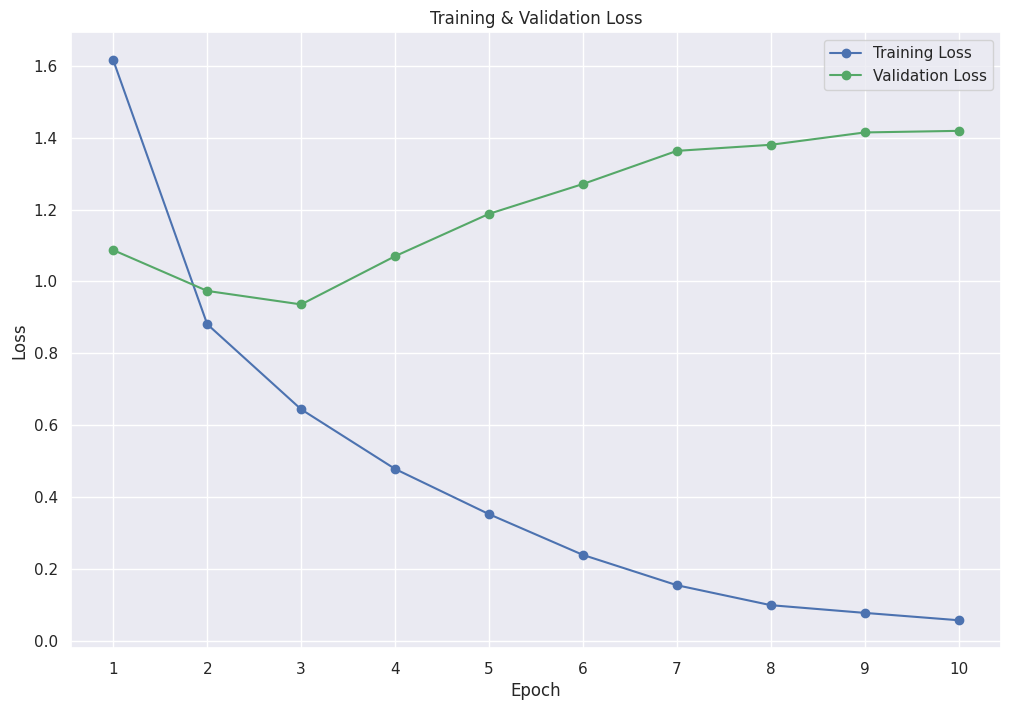

In [19]:
# Set the style for seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams['font.size'] = 14

# Plot the training and validation loss
plt.plot(df_stats['Training Loss'], 'b-o', label='Training Loss')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation Loss')

# Plot labels
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(range(1, epochs + 1))
plt.show()


**Plot Validation F1 Score**

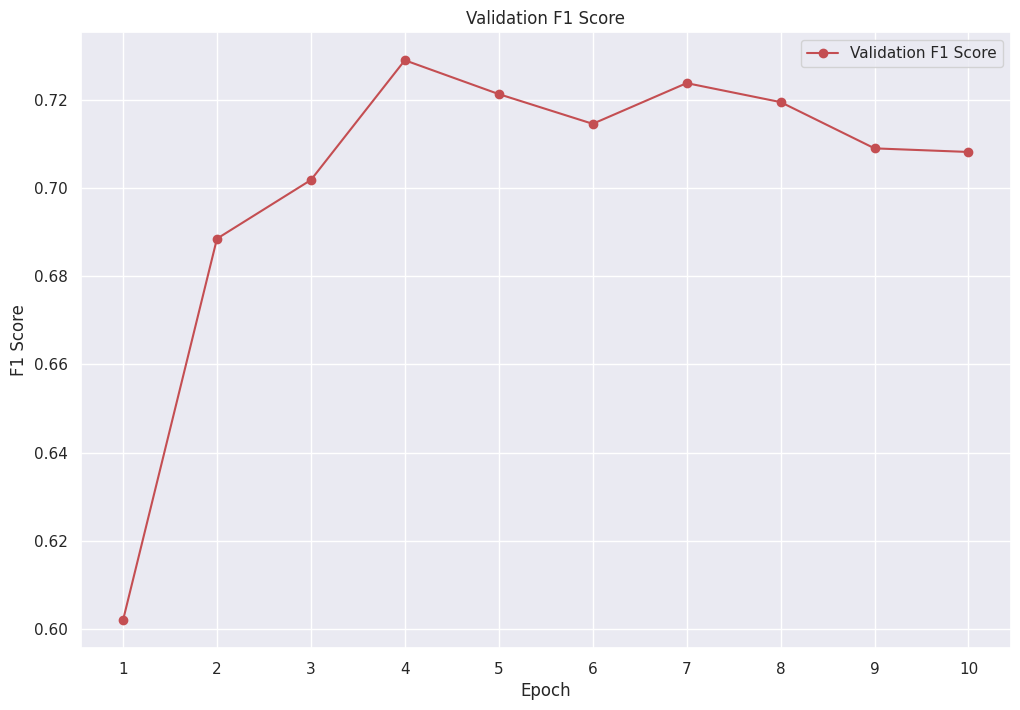

In [20]:
# Plot the validation F1 score
plt.plot(df_stats['Valid. F1'], 'r-o', label='Validation F1 Score')

# Plot labels
plt.title('Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.xticks(range(1, epochs + 1))
plt.show()


### **5. Ensuring Required Validation Metric**

Check if the best validation F1 score achieved during training meets the required threshold (≥ 0.60).

In [21]:
# Check if the best validation F1 score meets the requirement
if best_f1 >= 0.60:
    print(f"Best Validation F1 Score achieved: {best_f1:.2f} (Requirement met)")
else:
    print(f"Best Validation F1 Score achieved: {best_f1:.2f} (Requirement not met)")


Best Validation F1 Score achieved: 0.73 (Requirement met)


## **Step 3: Inference Using Fine-tuned Models**

### **1. Reconstruct the Dataset**

Since we need to use the **entire dataset** for inference (without splitting into train, validation, and test sets), we'll ensure that `df` contains all the samples.

In [22]:
# Verify sizes
print(f"Original number of samples: {sampled_companies.shape[0]}")
print(f"Number of samples after preprocessing: {df.shape[0]}")


Original number of samples: 2726
Number of samples after preprocessing: 1941


In [23]:
# Get label distribution
label_counts = df['label'].value_counts().sort_index()
print("Label distribution in the dataset:")
print(label_counts)


Label distribution in the dataset:
label
0    207
1    157
2    207
3    219
4    171
5    215
6    212
7    201
8    204
9    148
Name: count, dtype: int64


In [24]:
print(f"DataFrame 'df' size: {df.shape[0]}")
print(f"Input IDs tensor size: {input_ids.shape[0]}")
print(f"Attention masks tensor size: {attention_masks.shape[0]}")
print(f"Labels tensor size: {labels.shape[0]}")


DataFrame 'df' size: 1941
Input IDs tensor size: 1941
Attention masks tensor size: 1941
Labels tensor size: 1941


In [25]:
missing_count = sampled_companies.shape[0] - df.shape[0]
print(f"Number of companies excluded due to missing data: {missing_count}")


Number of companies excluded due to missing data: 785


### **2. Load Models and Tokenizers**

We need to:

- Load the tokenizer for each model.
- Load your fine-tuned BERT model from Step 2.
- Load the provided models (Sentence-BERT, Longformer, GPT-2).

**For GPT-2**, set `tokenizer.pad_token = tokenizer.eos_token` after loading the tokenizer.

**BERT**

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model for BERT
tokenizer_bert = AutoTokenizer.from_pretrained('./best_model/')  # Path to your saved tokenizer
model_bert = AutoModelForSequenceClassification.from_pretrained(
    './best_model/',  # Path to your saved model
    output_hidden_states=True
)
model_bert.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

**Sentence-BERT**

In [27]:
# Load Sentence-BERT tokenizer and model
tokenizer_sbert = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')

model_sbert = AutoModelForSequenceClassification.from_pretrained(
    'liqinye/sbert',
    output_hidden_states=True
)
model_sbert.to(device)


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

MPNetForSequenceClassification(
  (mpnet): MPNetModel(
    (embeddings): MPNetEmbeddings(
      (word_embeddings): Embedding(30527, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): MPNetEncoder(
      (layer): ModuleList(
        (0-11): 12 x MPNetLayer(
          (attention): MPNetAttention(
            (attn): MPNetSelfAttention(
              (q): Linear(in_features=768, out_features=768, bias=True)
              (k): Linear(in_features=768, out_features=768, bias=True)
              (v): Linear(in_features=768, out_features=768, bias=True)
              (o): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

**Longformer**

In [28]:
# Load Longformer tokenizer and model
tokenizer_longformer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')

model_longformer = AutoModelForSequenceClassification.from_pretrained(
    'liqinye/longformer',
    output_hidden_states=True
)
model_longformer.to(device)


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
          

**GPT-2**

In [29]:
# Load GPT-2 tokenizer and model
tokenizer_gpt2 = AutoTokenizer.from_pretrained('gpt2')
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token  # Set pad_token

model_gpt2 = AutoModelForSequenceClassification.from_pretrained(
    'liqinye/gpt2',
    output_hidden_states=True
)
model_gpt2.to(device)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=10, bias=False)
)

### **3. Tokenize the Dataset**

We need to tokenize the dataset separately for each model using their respective tokenizers.

**Tokenization Parameters**

Define tokenization parameters for each model:

**BERT and Sentence-BERT:**

In [30]:
tokenization_params = {
    'truncation': True,
    'padding': 'max_length',
    'max_length': 512,
    'return_tensors': 'pt'
}


**Longformer:**

Longformer can handle longer sequences. Adjust `max_length` accordingly (up to 4096 tokens).

In [31]:
tokenization_params_longformer = {
    'truncation': True,
    'padding': 'max_length',
    'max_length': 1024,  # You can increase up to 4096 if your GPU memory allows
    'return_tensors': 'pt'
}


**GPT-2:**

In [32]:
tokenization_params_gpt2 = {
    'truncation': True,
    'padding': 'max_length',
    'max_length': 512,
    'return_tensors': 'pt'
}


**Tokenize Texts**

Define a function to tokenize texts for each model:

In [33]:
def tokenize_texts(texts, tokenizer, params):
    input_ids_list = []
    attention_masks_list = []

    for text in tqdm(texts, desc='Tokenizing'):
        encoded_dict = tokenizer.encode_plus(
            text,
            **params
        )
        input_ids_list.append(encoded_dict['input_ids'])
        attention_masks_list.append(encoded_dict['attention_mask'])

    # Convert lists to tensors
    input_ids = torch.cat(input_ids_list, dim=0)
    attention_masks = torch.cat(attention_masks_list, dim=0)

    return input_ids, attention_masks


**Tokenize for Each Model**

**BERT:**

In [34]:
# Tokenize for BERT
input_ids_bert, attention_masks_bert = tokenize_texts(df['text'], tokenizer_bert, tokenization_params)


Tokenizing: 100%|██████████| 1941/1941 [00:55<00:00, 34.96it/s]


**Sentence-BERT:**

In [35]:
# Tokenize for Sentence-BERT
input_ids_sbert, attention_masks_sbert = tokenize_texts(df['text'], tokenizer_sbert, tokenization_params)


Tokenizing: 100%|██████████| 1941/1941 [00:55<00:00, 34.95it/s]


**Longformer:**

In [36]:
# Tokenize for Longformer
input_ids_longformer, attention_masks_longformer = tokenize_texts(df['text'], tokenizer_longformer, tokenization_params_longformer)


Tokenizing: 100%|██████████| 1941/1941 [00:50<00:00, 38.61it/s]


**GPT-2:**

In [37]:
# Tokenize for GPT-2
input_ids_gpt2, attention_masks_gpt2 = tokenize_texts(df['text'], tokenizer_gpt2, tokenization_params_gpt2)


Tokenizing: 100%|██████████| 1941/1941 [00:51<00:00, 37.65it/s]


**Create DataLoaders**

Create `TensorDataset` and `DataLoader` for each model:

**BERT:**

In [38]:
dataset_bert = TensorDataset(input_ids_bert, attention_masks_bert, labels)
dataloader_bert = DataLoader(dataset_bert, batch_size=16, shuffle=False)


**Sentence-BERT:**

In [39]:
dataset_sbert = TensorDataset(input_ids_sbert, attention_masks_sbert, labels)
dataloader_sbert = DataLoader(dataset_sbert, batch_size=16, shuffle=False)


**Longformer:**

In [40]:
dataset_longformer = TensorDataset(input_ids_longformer, attention_masks_longformer, labels)
dataloader_longformer = DataLoader(dataset_longformer, batch_size=4, shuffle=False)  # Adjust batch_size based on GPU memory


**GPT-2:**

In [41]:
dataset_gpt2 = TensorDataset(input_ids_gpt2, attention_masks_gpt2, labels)
dataloader_gpt2 = DataLoader(dataset_gpt2, batch_size=8, shuffle=False)


### **4. Perform Inference and Obtain Embeddings**

Define functions to perform inference and extract embeddings.

**For Encoder-only Models (BERT, Sentence-BERT, Longformer):**

In [42]:
def get_embeddings_and_predictions(model, dataloader):
    model.eval()
    embeddings = []
    true_labels = []
    pred_labels = []

    for batch in tqdm(dataloader, desc='Inference'):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels
            )

        # Get logits and hidden states
        logits = outputs.logits
        hidden_states = outputs.hidden_states

        # Extract embeddings from the [CLS] token
        cls_embeddings = hidden_states[-1][:, 0, :].cpu().numpy()
        embeddings.append(cls_embeddings)

        # Get predictions
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        pred_labels.extend(preds)
        true_labels.extend(b_labels.cpu().numpy())

    # Concatenate embeddings
    embeddings = np.concatenate(embeddings, axis=0)

    return embeddings, np.array(true_labels), np.array(pred_labels)


**For Decoder-only Model (GPT-2):**

In [43]:
def get_embeddings_and_predictions_gpt2(model, dataloader):
    model.eval()
    embeddings = []
    true_labels = []
    pred_labels = []

    for batch in tqdm(dataloader, desc='Inference'):
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_attention_mask,
                labels=b_labels
            )

        # Get logits and hidden states
        logits = outputs.logits
        hidden_states = outputs.hidden_states

        # Average embeddings over sequence length
        mean_embeddings = torch.mean(hidden_states[-1], dim=1).cpu().numpy()
        embeddings.append(mean_embeddings)

        # Get predictions
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        pred_labels.extend(preds)
        true_labels.extend(b_labels.cpu().numpy())

    # Concatenate embeddings
    embeddings = np.concatenate(embeddings, axis=0)

    return embeddings, np.array(true_labels), np.array(pred_labels)


**Run Inference for Each Model**

**BERT:**

In [44]:
print("Running inference for BERT...")
embeddings_bert, true_labels, pred_labels_bert = get_embeddings_and_predictions(model_bert, dataloader_bert)

# Calculate metrics
accuracy_bert = accuracy_score(true_labels, pred_labels_bert)
f1_bert = f1_score(true_labels, pred_labels_bert, average='weighted')

print(f"BERT Accuracy: {accuracy_bert:.2f}")
print(f"BERT F1 Score: {f1_bert:.2f}")


Running inference for BERT...


Inference: 100%|██████████| 122/122 [00:11<00:00, 10.39it/s]

BERT Accuracy: 0.88
BERT F1 Score: 0.88


**Sentence-BERT:**

In [45]:
print("Running inference for Sentence-BERT...")
embeddings_sbert, _, pred_labels_sbert = get_embeddings_and_predictions(model_sbert, dataloader_sbert)

# Calculate metrics
accuracy_sbert = accuracy_score(true_labels, pred_labels_sbert)
f1_sbert = f1_score(true_labels, pred_labels_sbert, average='weighted')

print(f"Sentence-BERT Accuracy: {accuracy_sbert:.2f}")
print(f"Sentence-BERT F1 Score: {f1_sbert:.2f}")


Running inference for Sentence-BERT...


Inference: 100%|██████████| 122/122 [00:15<00:00,  8.08it/s]

Sentence-BERT Accuracy: 0.84
Sentence-BERT F1 Score: 0.83


**Longformer:**

In [46]:
print("Running inference for Longformer...")
embeddings_longformer, _, pred_labels_longformer = get_embeddings_and_predictions(model_longformer, dataloader_longformer)

# Calculate metrics
accuracy_longformer = accuracy_score(true_labels, pred_labels_longformer)
f1_longformer = f1_score(true_labels, pred_labels_longformer, average='weighted')

print(f"Longformer Accuracy: {accuracy_longformer:.2f}")
print(f"Longformer F1 Score: {f1_longformer:.2f}")


Running inference for Longformer...


Inference: 100%|██████████| 486/486 [00:57<00:00,  8.40it/s]

Longformer Accuracy: 0.88
Longformer F1 Score: 0.88


**GPT-2:**

In [47]:
print("Running inference for GPT-2...")
embeddings_gpt2, _, pred_labels_gpt2 = get_embeddings_and_predictions_gpt2(model_gpt2, dataloader_gpt2)

# Calculate metrics
accuracy_gpt2 = accuracy_score(true_labels, pred_labels_gpt2)
f1_gpt2 = f1_score(true_labels, pred_labels_gpt2, average='weighted')

print(f"GPT-2 Accuracy: {accuracy_gpt2:.2f}")
print(f"GPT-2 F1 Score: {f1_gpt2:.2f}")


Running inference for GPT-2...


Inference: 100%|██████████| 243/243 [00:13<00:00, 17.95it/s]

GPT-2 Accuracy: 0.94
GPT-2 F1 Score: 0.94


### **5. Save Embeddings**

Save the embeddings for future analysis:

In [48]:
# Save embeddings
np.save('embeddings_bert.npy', embeddings_bert)
np.save('embeddings_sbert.npy', embeddings_sbert)
np.save('embeddings_longformer.npy', embeddings_longformer)
np.save('embeddings_gpt2.npy', embeddings_gpt2)

# Save true labels
np.save('true_labels.npy', true_labels)


### **6. Report Classification Metrics**

Create a DataFrame to display the metrics for each model:

In [49]:
# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'Model': ['BERT', 'Sentence-BERT', 'Longformer', 'GPT-2'],
    'Accuracy': [accuracy_bert, accuracy_sbert, accuracy_longformer, accuracy_gpt2],
    'F1 Score': [f1_bert, f1_sbert, f1_longformer, f1_gpt2]
})

# Format the metrics to two decimal places
metrics_df['Accuracy'] = metrics_df['Accuracy'].apply(lambda x: f"{x:.2f}")
metrics_df['F1 Score'] = metrics_df['F1 Score'].apply(lambda x: f"{x:.2f}")

# Display the table
print(metrics_df)


           Model Accuracy F1 Score
0           BERT     0.88     0.88
1  Sentence-BERT     0.84     0.83
2     Longformer     0.88     0.88
3          GPT-2     0.94     0.94


## **Step 4: Clustering Using Embeddings**

In this step, clustering is performed on the embeddings obtained from the fine-tuned models. The goal is to visualize the clusters and analyze their effectiveness.

### **1. Visualize Clusters with PCA**

**Objective:**

- Reduce the dimensionality of embeddings to 2D using PCA.
- Plot the embeddings for each model, coloring each point by its sector label.
- Analyze the plots based on clustering visualization.

**Load Embeddings and Labels**

First, load the saved embeddings and true labels.

In [50]:
# Load embeddings and labels
embeddings_bert = np.load('embeddings_bert.npy')
embeddings_sbert = np.load('embeddings_sbert.npy')
embeddings_longformer = np.load('embeddings_longformer.npy')
embeddings_gpt2 = np.load('embeddings_gpt2.npy')

true_labels = np.load('true_labels.npy')


**Perform PCA on Embeddings**

Reduce the dimensionality of embeddings to 2D for visualization.

In [51]:
from sklearn.decomposition import PCA

def perform_pca(embeddings):
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings)
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"Explained variance by 2 principal components: {explained_variance:.2%}")
    return embeddings_pca


Apply PCA to each model's embeddings:

In [52]:
# BERT
print("BERT:")
embeddings_bert_pca = perform_pca(embeddings_bert)

# Sentence-BERT
print("Sentence-BERT:")
embeddings_sbert_pca = perform_pca(embeddings_sbert)

# Longformer
print("Longformer:")
embeddings_longformer_pca = perform_pca(embeddings_longformer)

# GPT-2
print("GPT-2:")
embeddings_gpt2_pca = perform_pca(embeddings_gpt2)


BERT:
Explained variance by 2 principal components: 31.64%
Sentence-BERT:
Explained variance by 2 principal components: 33.77%
Longformer:
Explained variance by 2 principal components: 32.60%
GPT-2:
Explained variance by 2 principal components: 84.02%


**Plot Embeddings with Sector Labels**

Define a function to plot the PCA-reduced embeddings.

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_embeddings(embeddings_pca, labels, title):
    plt.figure(figsize=(10,8))
    sns.scatterplot(
        x=embeddings_pca[:,0],
        y=embeddings_pca[:,1],
        hue=labels,
        palette='tab10',
        legend='full',
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Sector')
    plt.show()


Plot the embeddings for each model:

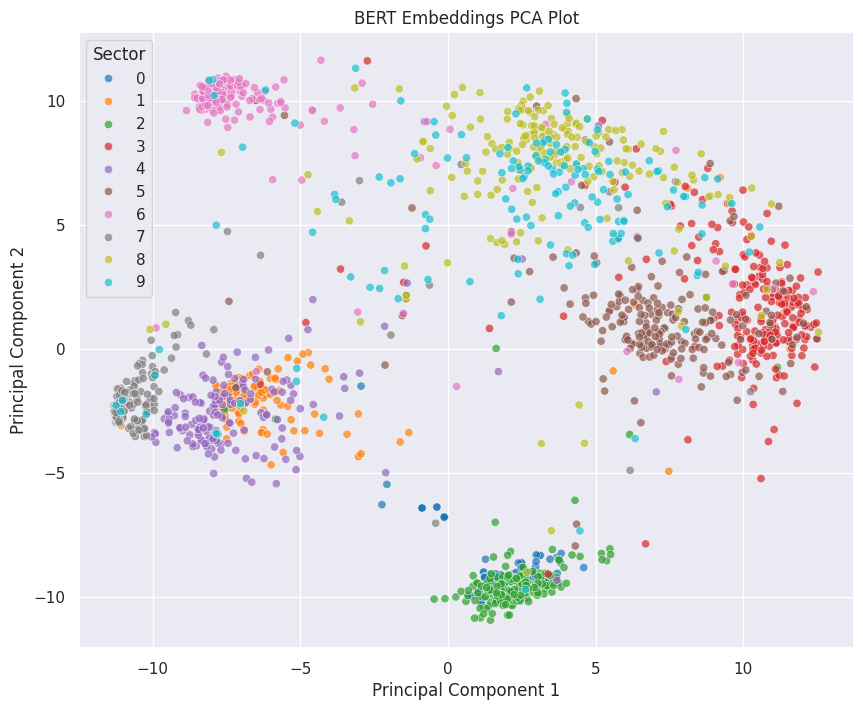

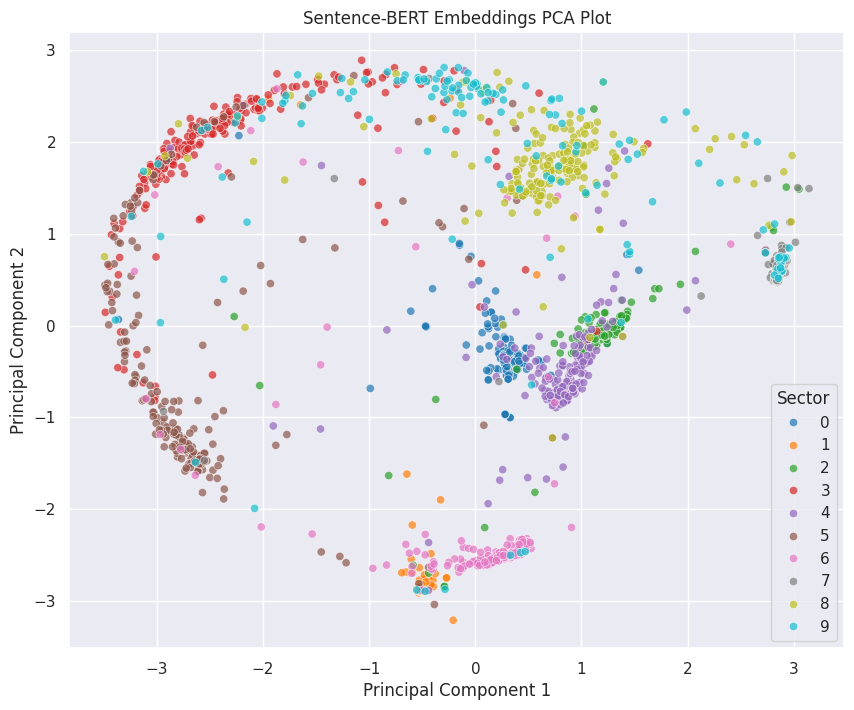

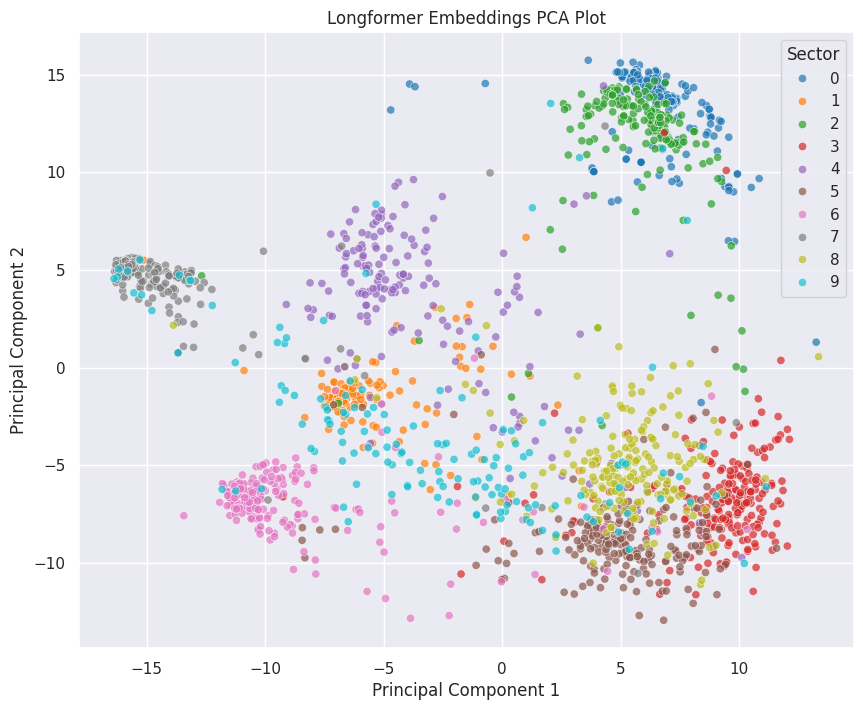

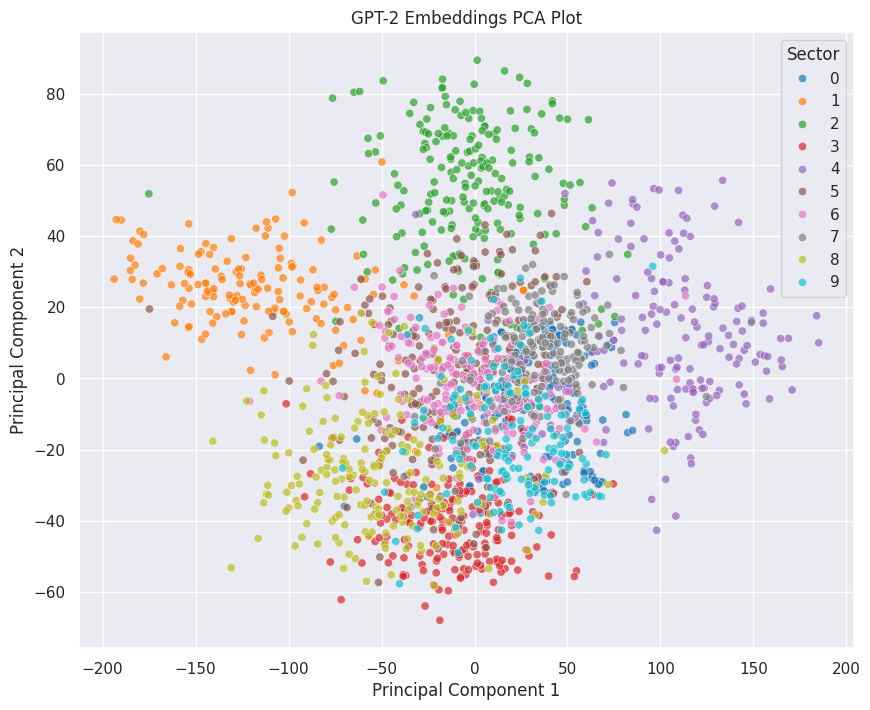

In [54]:
# BERT
plot_embeddings(embeddings_bert_pca, true_labels, 'BERT Embeddings PCA Plot')

# Sentence-BERT
plot_embeddings(embeddings_sbert_pca, true_labels, 'Sentence-BERT Embeddings PCA Plot')

# Longformer
plot_embeddings(embeddings_longformer_pca, true_labels, 'Longformer Embeddings PCA Plot')

# GPT-2
plot_embeddings(embeddings_gpt2_pca, true_labels, 'GPT-2 Embeddings PCA Plot')


---

### **Analysis of Clustering Visualization**

**a. Determining the Best Performing Model Based on Visualization**

Based on the clustering visualization, **BERT** appears to perform the best. The BERT embeddings display very distinct and dense clusters for multiple sectors, with minimal overlap between them. The clusters are well-separated along the axes, enhancing interpretability and indicating effective grouping of companies within the same sector.

This distinct clustering is consistent with BERT's high F1 score and accuracy of **0.88**. While GPT-2 achieved slightly higher metrics (accuracy and F1 score of **0.94**), its embeddings exhibit significant overlaps and less dense clusters. The clear separation in BERT's embeddings suggests that it is more effective in capturing sector-specific features, making its embeddings more useful for tasks requiring precise class distinctions.

**b. Comparing Decoder-only and Encoder-only Model Embeddings**

When comparing decoder-only and encoder-only model embeddings, several takeaways emerge:

- **Encoder-only Models (BERT, Sentence-BERT, Longformer):**
  - **BERT:** Shows very distinct and dense clusters with minimal overlap, indicating strong separability between sectors.
  - **Sentence-BERT:** Exhibits an arc-shaped clustering with significant overlap, suggesting that its embeddings are less effective for classification tasks requiring clear separation.
  - **Longformer:** Displays clusters that are less condensed than BERT's, with noticeable overlaps among certain sectors.

- **Decoder-only Model (GPT-2):**
  - GPT-2's embeddings are widely spread across the embedding space, capturing a high explained variance of **84.02%**. However, the clusters are less dense and have significant overlaps, which may complicate interpretability despite the model's high classification performance.

**Takeaways:**

- **Encoder-only models** like BERT can produce more distinct and interpretable clusters, which is advantageous for classification tasks where clear separation between classes is important.
- **Decoder-only models** like GPT-2 may achieve higher performance metrics but at the cost of less distinct clustering, making interpretation of the embeddings more challenging.
- The choice between models may depend on the specific requirements of the task, balancing the need for interpretability versus maximum classification performance.

**c. Interpretation of Overlapping Clusters**

The presence of overlapping clusters indicates that some sectors share similarities in their business descriptions. This overlap can occur due to:

- **Shared Vocabulary:** Companies across different sectors may use similar language to describe their operations, strategies, or market conditions.
- **Common Themes:** Certain themes or topics may be prevalent in multiple sectors, leading to embeddings that are close in the vector space.

**Implications:**

- **Challenge in Distinction:** Overlapping clusters highlight the difficulty in distinguishing between sectors based solely on textual data, as inherent similarities may blur the lines between categories.
- **Model Interpretation:** The overlaps suggest that the model is capturing underlying patterns that are common across sectors, which may require additional features or more advanced models to disentangle.
- **Further Refinement:** Understanding the reasons behind the overlaps can inform strategies to improve model performance, such as incorporating domain-specific knowledge or leveraging more granular data.

---

**Summary:**

- **BERT** is considered the best-performing model based on clustering visualization due to its distinct and dense clusters, which align with its high F1 score and accuracy.
- **Encoder-only models** like BERT provide more interpretable embeddings with clear class separation, while **decoder-only models** like GPT-2, despite higher performance metrics, produce less distinct clusters.
- **Overlapping clusters** indicate shared characteristics among sectors, underscoring challenges in text-based classification and the importance of considering domain-specific nuances.

---

### **2. Perform K-means Clustering with k=3**

**Objective:**

- Cluster the embeddings into 3 clusters using K-means.
- Visualize the clusters on the PCA-reduced embeddings.

**Perform K-means Clustering**


In [55]:
from sklearn.cluster import KMeans

def perform_kmeans(embeddings, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(embeddings)
    return kmeans.labels_


Apply K-means to each model's embeddings:

In [56]:
# BERT
labels_bert_kmeans = perform_kmeans(embeddings_bert)

# Sentence-BERT
labels_sbert_kmeans = perform_kmeans(embeddings_sbert)

# Longformer
labels_longformer_kmeans = perform_kmeans(embeddings_longformer)

# GPT-2
labels_gpt2_kmeans = perform_kmeans(embeddings_gpt2)


**Plot Embeddings with K-means Clusters**

Define a function to plot embeddings colored by K-means cluster labels.

In [60]:
def plot_embeddings_kmeans(embeddings_pca, cluster_labels, title):
    plt.figure(figsize=(10,8))
    sns.scatterplot(
        x=embeddings_pca[:,0],
        y=embeddings_pca[:,1],
        hue=cluster_labels,
        palette='Set1',
        legend='full',
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.show()


Plot the clusters for each model:

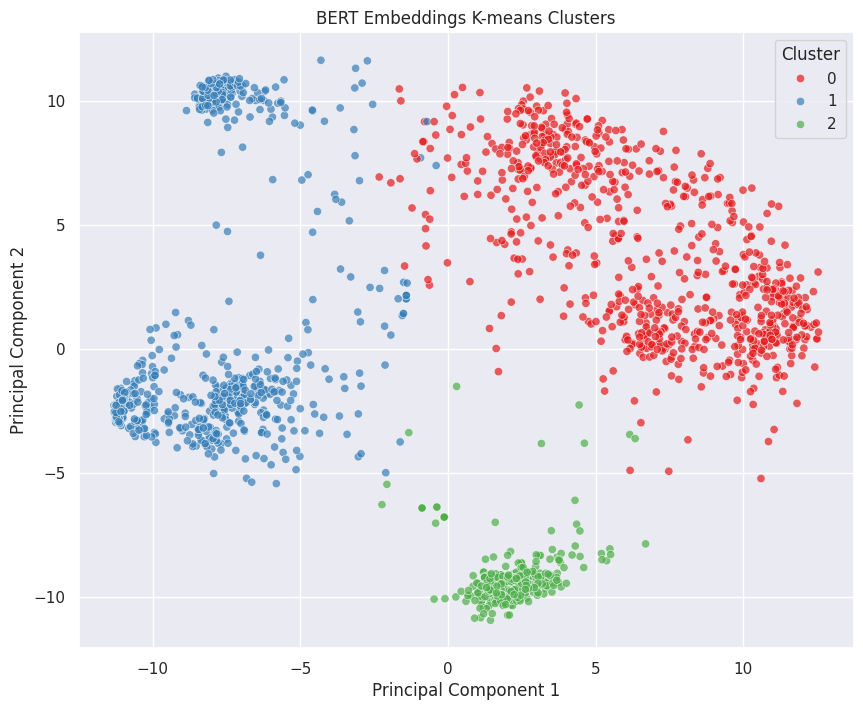

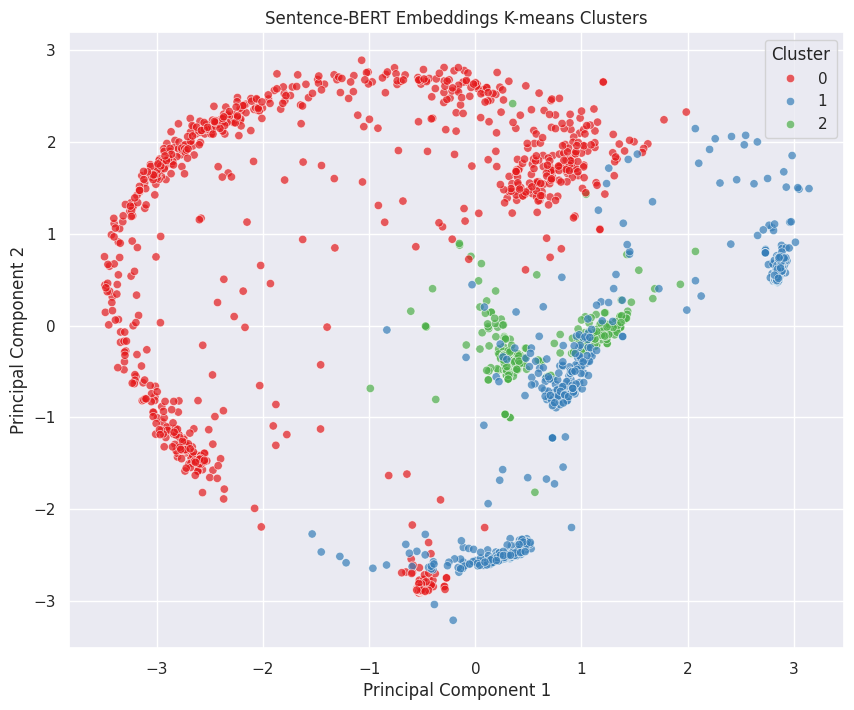

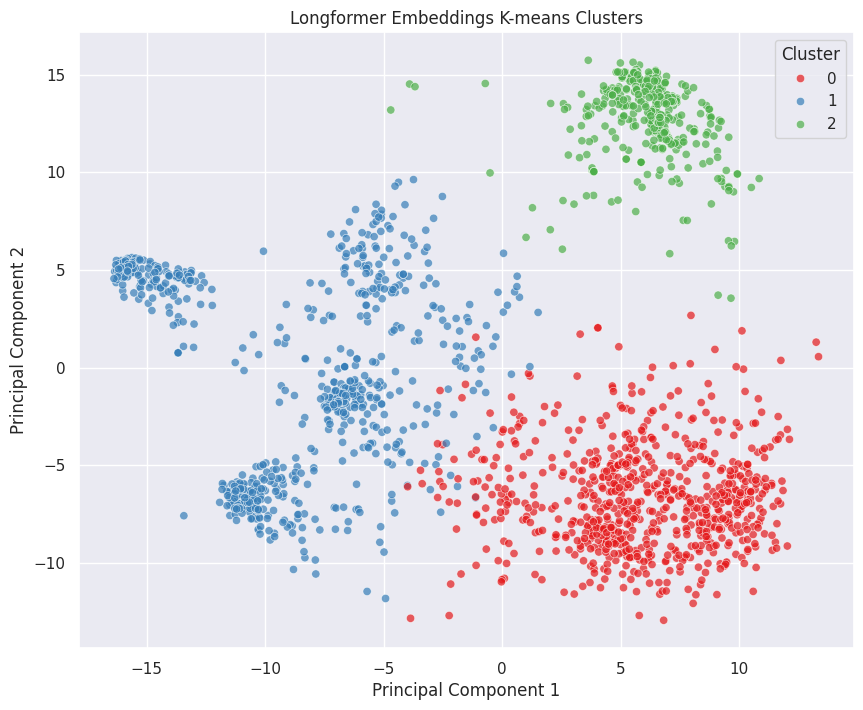

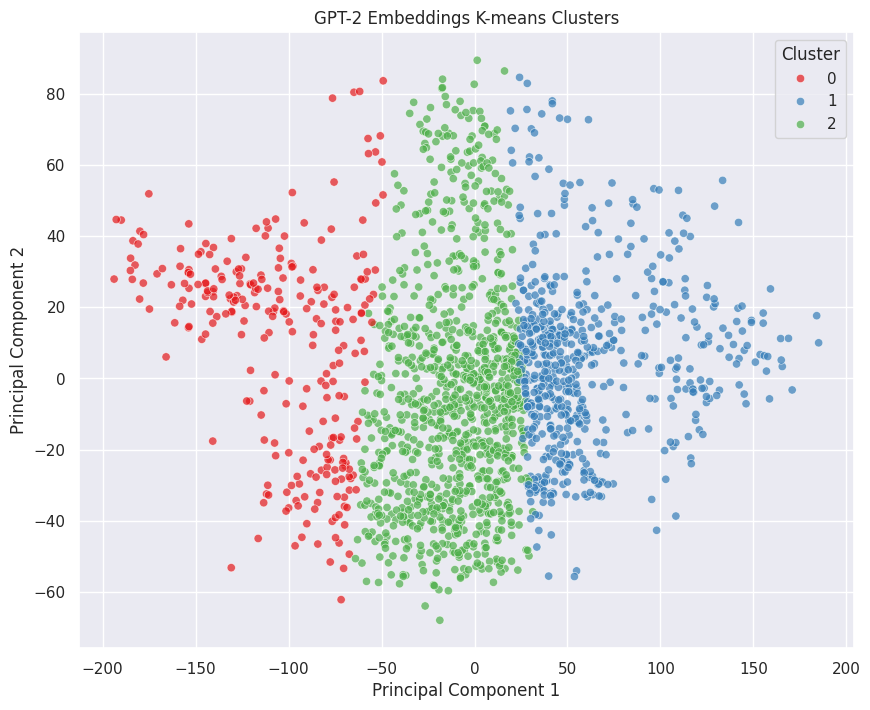

In [62]:
# BERT
plot_embeddings_kmeans(embeddings_bert_pca, labels_bert_kmeans, 'BERT Embeddings K-means Clusters')

# Sentence-BERT
plot_embeddings_kmeans(embeddings_sbert_pca, labels_sbert_kmeans, 'Sentence-BERT Embeddings K-means Clusters')

# Longformer
plot_embeddings_kmeans(embeddings_longformer_pca, labels_longformer_kmeans, 'Longformer Embeddings K-means Clusters')

# GPT-2
plot_embeddings_kmeans(embeddings_gpt2_pca, labels_gpt2_kmeans, 'GPT-2 Embeddings K-means Clusters')


## **Step 5: Portfolio Analysis**

In this final step, portfolios will be created based on the clusters assigned via K-means clustering on the BERT embeddings. Both equal-weighted and value-weighted portfolios will be formed, and their cumulative returns will be plotted along with the market return for comparison.

### **1. Form Equal-Weighted Portfolios and Compute Cumulative Returns**

**Load Embeddings and Clusters**

Since **BERT** was chosen as the best model, we'll use the K-means clusters obtained from BERT embeddings.

In [63]:
# Load BERT embeddings and true labels
embeddings_bert = np.load('embeddings_bert.npy')
true_labels = np.load('true_labels.npy')

# Perform K-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans.fit(embeddings_bert)
cluster_labels = kmeans.labels_

# Add cluster labels to the DataFrame
df['Cluster'] = cluster_labels


**Load Stock Return Data**

Load the CRSP monthly stock data (`MSF_1996_2023.csv`) and preprocess it.

In [70]:
# Load stock data
stock_data = pd.read_csv('MSF_1996_2023.csv')

# Ensure PERMNO is of integer type
stock_data['PERMNO'] = stock_data['PERMNO'].astype(int)

# Convert date column to datetime format
stock_data['date'] = pd.to_datetime(stock_data['date'], format='%Y-%m-%d')

# Keep relevant columns
stock_data = stock_data[['PERMNO', 'date', 'RET', 'PRC', 'SHROUT']]

# Clean data: Remove rows with missing or invalid returns
stock_data = stock_data[stock_data['RET'].notnull()]
stock_data = stock_data[stock_data['RET'] != 'C']
stock_data = stock_data[stock_data['RET'] != 'B']

# Convert RET to numeric
stock_data['RET'] = pd.to_numeric(stock_data['RET'], errors='coerce')
stock_data = stock_data.dropna(subset=['RET'])

# Convert the 'PRC' column to its absolute values
stock_data['PRC'] = stock_data['PRC'].abs()

# Calculate market capitalization (in millions)
stock_data['mktcap'] = stock_data['PRC'].abs() * stock_data['SHROUT'] / 1e3  # SHROUT in thousands

# Print the first few rows of the dataframe
stock_data.head()


<ipython-input-70-23ba40ddf6df>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  stock_data = pd.read_csv('MSF_1996_2023.csv')


PERMNO       date       RET      PRC  SHROUT     mktcap
0   10001 1996-01-31 -0.026667  9.12500  2281.0  20.814125
1   10001 1996-02-29  0.013699  9.25000  2281.0  21.099250
2   10001 1996-03-29  0.036149  9.48438  2309.0  21.899433
3   10001 1996-04-30 -0.070840  8.81250  2309.0  20.348063
4   10001 1996-05-31 -0.021277  8.62500  2309.0  19.915125

**Merge Clusters with Stock Data**

In [71]:
# Prepare df for merging
df_merge = df[['PERMNO', 'year', 'Cluster']].drop_duplicates()

# Create 'date' column corresponding to December of the filing year
df_merge['date'] = pd.to_datetime(df_merge['year'].astype(str) + '1231', format='%Y%m%d')

# Merge df_merge with stock_data
merged_data = pd.merge(stock_data, df_merge, on=['PERMNO'], how='inner')

# Filter data to include dates from the filing year onwards
merged_data = merged_data[merged_data['date_x'] >= merged_data['date_y']]

# Rename columns for clarity
merged_data.rename(columns={'date_x': 'date'}, inplace=True)


**Form Equal-Weighted Portfolios**

In [72]:
# Sort data by date
merged_data.sort_values(by='date', inplace=True)

# Group data by date and cluster
grouped = merged_data.groupby(['date', 'Cluster'])

# Calculate equal-weighted returns
equal_weighted_returns = grouped['RET'].mean().reset_index()

# Pivot the data to have clusters as columns
equal_weighted_returns_pivot = equal_weighted_returns.pivot(index='date', columns='Cluster', values='RET')

# Fill missing values with 0
equal_weighted_returns_pivot = equal_weighted_returns_pivot.fillna(0)

# Calculate cumulative returns
cumulative_returns_equal = (1 + equal_weighted_returns_pivot).cumprod()


**Calculate Market Return**

In [73]:
# Calculate market return (equal-weighted)
market_returns = stock_data.groupby('date')['RET'].mean()

# Calculate cumulative market return
cumulative_market_return = (1 + market_returns).cumprod()


**Plot Cumulative Returns**

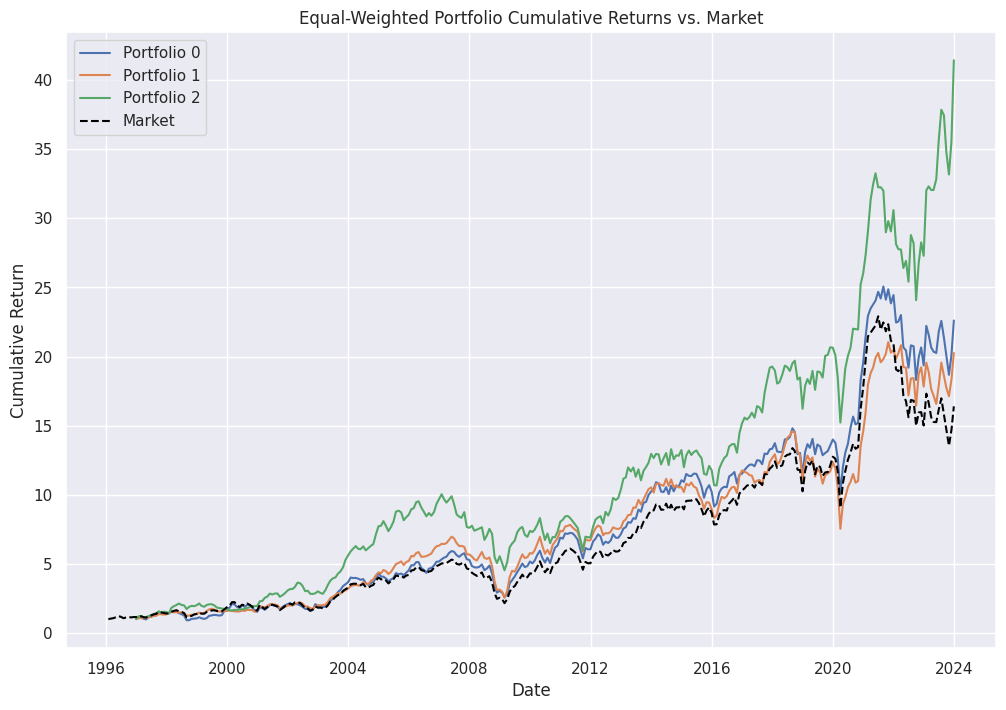

In [74]:
# Plot cumulative returns of portfolios and market
plt.figure(figsize=(12,8))
for cluster in cumulative_returns_equal.columns:
    plt.plot(cumulative_returns_equal.index, cumulative_returns_equal[cluster], label=f'Portfolio {cluster}')

plt.plot(cumulative_market_return.index, cumulative_market_return.values, label='Market', linestyle='--', color='black')

plt.title('Equal-Weighted Portfolio Cumulative Returns vs. Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


### **2. Form Value-Weighted Portfolios and Compute Cumulative Returns**

**Calculate Value-Weighted Returns**

In [75]:
# Function to calculate value-weighted returns
def calculate_value_weighted_returns(data):
    data['weight'] = data['mktcap']
    data['weighted_ret'] = data['RET'] * data['weight']
    grouped = data.groupby(['date', 'Cluster'])
    sum_weighted_ret = grouped['weighted_ret'].sum()
    sum_weights = grouped['weight'].sum()
    value_weighted_returns = (sum_weighted_ret / sum_weights).reset_index()
    return value_weighted_returns

# Calculate value-weighted returns
value_weighted_returns = calculate_value_weighted_returns(merged_data)

# Pivot the data to have clusters as columns
value_weighted_returns_pivot = value_weighted_returns.pivot(index='date', columns='Cluster', values=0)

# Fill missing values with 0
value_weighted_returns_pivot = value_weighted_returns_pivot.fillna(0)

# Calculate cumulative returns
cumulative_returns_value = (1 + value_weighted_returns_pivot).cumprod()


**Calculate Value-Weighted Market Return**

In [76]:
# Calculate market return (value-weighted)
stock_data['weight'] = stock_data['mktcap']
stock_data['weighted_ret'] = stock_data['RET'] * stock_data['weight']
market_sum_weighted_ret = stock_data.groupby('date')['weighted_ret'].sum()
market_sum_weights = stock_data.groupby('date')['weight'].sum()
market_value_weighted_returns = market_sum_weighted_ret / market_sum_weights

# Calculate cumulative market return
cumulative_market_return_value = (1 + market_value_weighted_returns).cumprod()


**Plot Cumulative Returns**

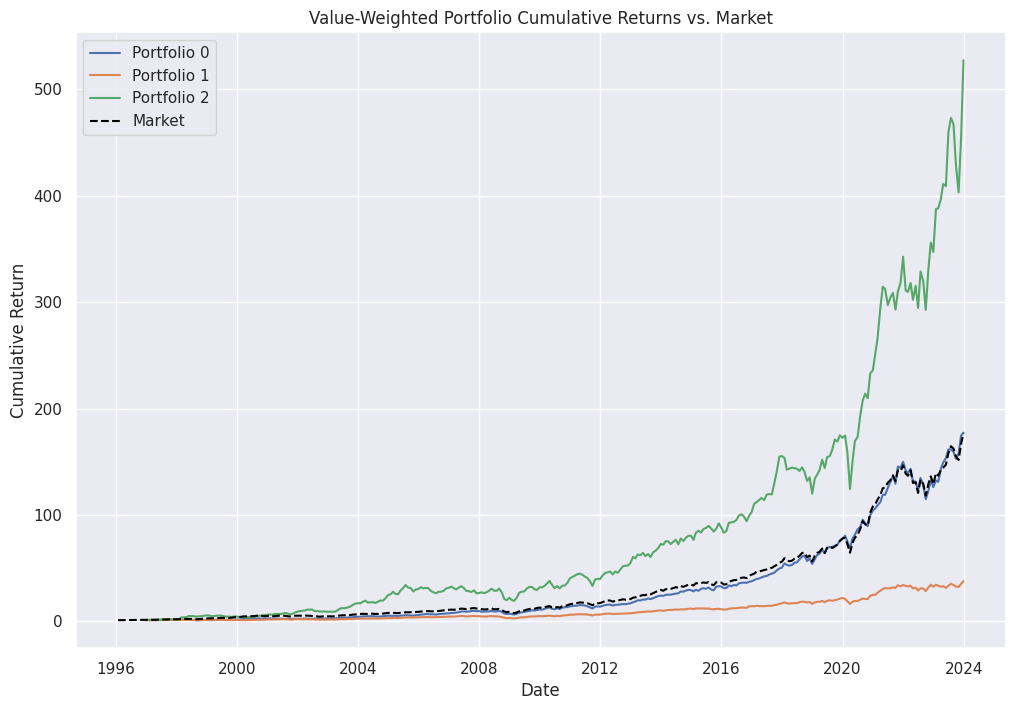

In [77]:
# Plot cumulative returns of portfolios and market
plt.figure(figsize=(12,8))
for cluster in cumulative_returns_value.columns:
    plt.plot(cumulative_returns_value.index, cumulative_returns_value[cluster], label=f'Portfolio {cluster}')

plt.plot(cumulative_market_return_value.index, cumulative_market_return_value.values, label='Market', linestyle='--', color='black')

plt.title('Value-Weighted Portfolio Cumulative Returns vs. Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


---

#### **Comments on Observations**

**Equal-Weighted Portfolio Cumulative Returns vs. Market**

- **Overview:**
  - The graph illustrates the cumulative returns of three portfolios—**Portfolio 0**, **Portfolio 1**, and **Portfolio 2**—compared to the market return in an equal-weighted setup from 1996 to 2024.
  - The x-axis represents the time period from 1996 to 2024, while the y-axis shows the cumulative return, ranging from 0 to 45.

- **Performance Trends:**
  - **1996 to 2004:** All portfolios and the market exhibit modest growth, closely tracking each other with minimal divergence.
  - **2004 to 2012:** Slight increases in returns are observed, but there's no substantial divergence among Portfolios 0 and 1 or from the market. **Portfolio 2** occasionally outperforms the market but converges with the others by 2012.
  - **Post-2012:** **Portfolio 2** begins to outperform significantly, showing a stronger upward trend compared to the others.
    - By 2020, there's a notable surge in **Portfolio 2's** cumulative return.
    - By 2024, **Portfolio 2** peaks near a cumulative return of **43**, outpacing both the market and the other portfolios.
  - **Portfolios 0 and 1** exhibit similar growth patterns throughout the period, staying slightly above the market but below **Portfolio 2**.

- **Insights:**
  - The consistent outperformance of **Portfolio 2** suggests that the companies within this cluster possess characteristics leading to higher returns when equally weighted.
  - The similar performance of **Portfolios 0 and 1** to the market indicates that their constituent companies closely mirror overall market trends in an equal-weighted context.

**Value-Weighted Portfolio Cumulative Returns vs. Market**

- **Overview:**
  - This graph presents the cumulative returns using a value-weighted approach, where larger companies have a more significant impact on portfolio returns.
  - The y-axis ranges from 0 to 550, reflecting the influence of market capitalization on the portfolios' performance.

- **Performance Trends:**
  - **1996 to 2004:** All portfolios and the market follow a relatively flat trajectory, with minimal growth.
  - **Post-2004:** **Portfolio 2** begins to diverge, increasing more sharply than the others.
    - Around 2012, **Portfolio 2** shows significant growth, substantially pulling ahead of the market and other portfolios.
    - By 2024, **Portfolio 2** reaches an extraordinary cumulative return of approximately **525**, vastly exceeding both the market and the other portfolios.
  - **Portfolios 0 and 1**, along with the market, remain much lower throughout the period:
    - **Portfolio 1** underperforms significantly compared to the market.
    - **Portfolio 0** performs almost identically to the market.
    - Their cumulative returns range around **50 to 150** by the end of the period, highlighting the substantial performance gap between **Portfolio 2** and the others in a value-weighted context.

- **Insights:**
  - The dramatic outperformance of **Portfolio 2** in the value-weighted scenario indicates that larger companies within this cluster contribute significantly to its high returns.
  - The underperformance of **Portfolio 1** suggests that larger companies in this cluster may be lagging, negatively impacting the portfolio's overall returns.
  - **Portfolio 0's** alignment with market performance implies that its constituent companies collectively mimic the broader market when weighted by capitalization.

**Summary Comparison**

- **Equal-Weighted vs. Value-Weighted:**
  - In the equal-weighted scenario, all portfolios exhibit modest growth, with **Portfolio 2** consistently outperforming and reaching a cumulative return of about **43** by 2024.
  - The value-weighted scenario amplifies the differences:
    - **Portfolio 2's** cumulative return soars to approximately **550**, showcasing the significant impact of larger companies within the cluster.
    - The magnitude of **Portfolio 2's** lead is much more dramatic in the value-weighted context, highlighting the importance of company size in driving returns.
    - **Portfolios 0 and 1** do not benefit as much from the value-weighted approach, with **Portfolio 1** notably underperforming the market.

- **Implications:**
  - **Portfolio 2's** standout performance in both scenarios suggests that the clustering based on BERT embeddings effectively identified a group of companies with superior return characteristics.
  - The substantial outperformance in the value-weighted portfolio underscores the influence of large-cap companies within **Portfolio 2**, indicating that these firms have driven much of the portfolio's gains.
  - The divergence in performance between the equal-weighted and value-weighted portfolios highlights how company size and market capitalization can significantly affect investment outcomes.

**Final Remarks**

- The analysis demonstrates that text-based clustering using BERT embeddings can successfully group companies in a way that reflects meaningful differences in stock performance.
- **Portfolio 2's** exceptional returns, especially in the value-weighted scenario, suggest that the embeddings captured characteristics associated with higher-performing, larger companies.
- The underperformance of **Portfolio 1**, particularly in the value-weighted context, indicates that the cluster may contain larger companies with poorer performance, or that the cluster as a whole did not capture high-growth sectors.
- These findings highlight the potential of incorporating natural language processing and clustering techniques into financial analysis to enhance portfolio construction and investment strategies.
- Investors might consider leveraging such methodologies to identify clusters of companies that could offer superior returns, taking into account both the equal-weighted and value-weighted perspectives to balance exposure to company size.

---